In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,GlobalAveragePooling2D, Concatenate, Reshape,GlobalMaxPooling2D, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
from PIL import Image
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import pathlib
import datetime
import math
import sys
import neptune

def plotFromCsv(file):

    data = np.genfromtxt(file, delimiter=',', skip_header=1, names=['epoch','loss','mse','val_loss','val_mse'])
    plt.figure(figsize=(20,10))
    plt.plot(data['epoch'],data['val_loss'])
    plt.plot(data['epoch'],data['loss'])
    plt.title('Model accuracy (' +str(file)+")")
    plt.ylabel('Loss (MSE) (KG)')
    plt.xlabel('Epoch')
    plt.legend(['Validation Loss','Loss'], loc='upper right')
    plt.ylim(0,0.8)
    plt.show()

In [4]:
import neptune
key = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOWUxN2YwMTUtNjM1Ny00NmVlLWIzOTctNzAwYTllMGNmMTg2In0="
project = neptune.init('lassegoransson/xrayPredictor-448x448',api_token=key)

In [5]:
name = "XRAY448-23"

In [6]:
!rm output/*
ex = exp = project.get_experiments(name)[0]
ex.download_artifacts()
!unzip output.zip

Archive:  output.zip
  inflating: output/model_resnet_18_0layer.py_checkpoint-448x448-032-0.0064063910394907.hdf5  


In [7]:
files = !find output/ -name "model*"
files

['output/model_resnet_18_0layer.py_checkpoint-448x448-032-0.0064063910394907.hdf5']

In [8]:
modelname = files[0]
modelpath = str(modelname.split("/")[1])
print(modelpath)
model = tf.keras.models.load_model(modelname, custom_objects={'Activation': tf.keras.layers.Activation})

model_resnet_18_0layer.py_checkpoint-448x448-032-0.0064063910394907.hdf5


In [9]:
image_height = 448
image_width = 448
test_df = pandas.read_csv("/home/lasg/bachelor-data/data/allTest.csv")
test_datagen = ImageDataGenerator(
        rescale=1./255,
        )

if model.input_shape[3] == 1:
    
    test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory='/home/lasg/bachelor-data/data_448/',
            x_col="filename",
            y_col='label',
            target_size=(image_height, image_width),
            batch_size=1,
            shuffle=False,
            class_mode="raw",
            color_mode="grayscale"
            #color_mode="rgb"
            )
else: 
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory='/home/lasg/bachelor-data/data_448/',
            x_col="filename",
            y_col='label',
            target_size=(image_height, image_width),
            batch_size=1,
            shuffle=False,
            class_mode="raw",
            #color_mode="grayscale"
            color_mode="rgb"
            )
        

Found 806 validated image filenames.


# Evaluate




In [10]:
n = []
nnon=[]
mse=0
hits=[0,0,0,0,0,0]
labeltrueVal = 0
labelval = 0
i=0
for b in range(0,test_generator.n):
  img,y= test_generator.next()
  img=img[0]
  sys.stdout.write("\r" + str(100*i/test_generator.n))
  label = y[0]
  predict = model.predict(np.expand_dims(img, axis=0))[0][0]
  val =(1-(label/predict))
  mse+=((1/test_generator.n)*(label-predict)*(label-predict))
  nnon.append(val)
  val=abs(val)
  n.append(val)
  if val < 0.05:
    hits[0] += 1
  if val < 0.10:
    hits[1] += 1
  if val < 0.15:
    hits[2] += 1
  if val < 0.20:
    hits[3] += 1
  if val < 0.25:
    hits[4] += 1
  if val < 0.30:
    hits[5] += 1

  #BATCH
  labeltrueVal += label
  labelval +=predict
  i+=1
  

4.34243176178661236

/home/lasg/bachelor-code/evaluator/evalenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


99.875930521091826

# Model Architecture

In [11]:
modelname.split("/")[1]

'model_resnet_18_0layer.py_checkpoint-448x448-032-0.0064063910394907.hdf5'

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# SCORE

In [16]:
print("")
print("MSE: "+str(mse))
print("")
print("Deviation from true weight (< 5% = 90 is project goal)")
print("< 5.0% = " +  str(100*hits[0]/(test_generator.n))+ "%")
print("< 10.0% = " + str(100*hits[1]/(test_generator.n))+ "%")
print("< 15.0% = " + str(100*hits[2]/(test_generator.n))+ "%")
print("< 20.0% = " + str(100*hits[3]/(test_generator.n))+ "%")
print("< 25.0% = " + str(100*hits[4]/(test_generator.n))+ "%")
print("< 30.0% = " + str(100*hits[5]/(test_generator.n))+ "%")
print("")
print("Deviation summed over full batch")
print("Predicted weight: "+str(labelval)+" True weight: "+str(labeltrueVal)+" Percentage: "+str((labelval/labeltrueVal)*100))


MSE: 0.0064063905789142825

Deviation from true weight (< 5% = 90 is project goal)
< 5.0% = 40.81885856079405%
< 10.0% = 71.46401985111663%
< 15.0% = 88.21339950372209%
< 20.0% = 92.43176178660049%
< 25.0% = 94.41687344913151%
< 30.0% = 95.40942928039702%

Deviation summed over full batch
Predicted weight: 533.8231713622808 True weight: 534.0040000000014 Percentage: 99.9661372128822


In [14]:
ex.log_metric("5%_score",100*hits[0]/(test_generator.n))

# Residuals

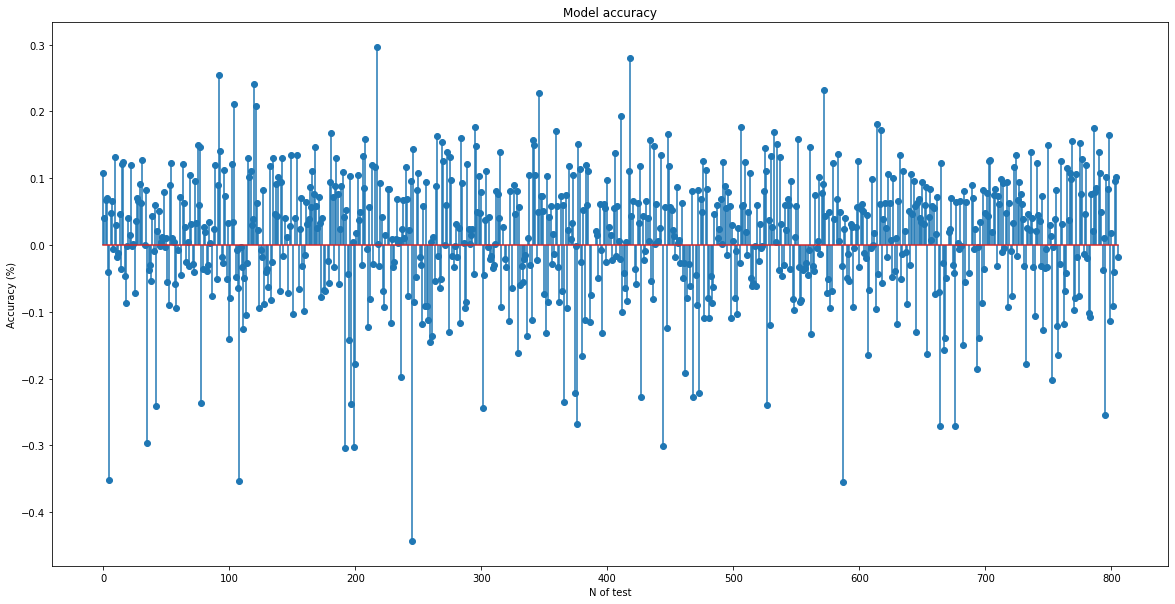

In [15]:
plt.figure(figsize=(20,10))
plt.stem(range(0,len(n)),nnon,use_line_collection=True)
plt.title('Model accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('N of test')
plt.show()